In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

torch.Size([3, 386, 3, 64, 64])

In [2]:
T = 100
beta = torch.linspace(10e-4, 0.02, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.3475, device='cuda:0')

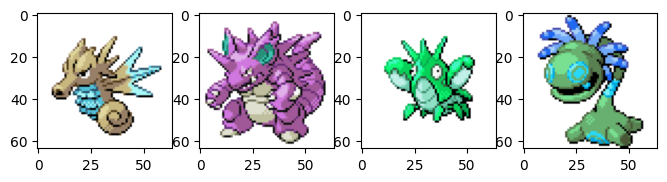

In [3]:
transform = v2.Compose([
    v2.ColorJitter(),
    v2.RandomChannelPermutation(),
    v2.RandomGrayscale(p = 0.1),
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(8, 5))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [4]:
model = UNet(3, 3).to(device)

loss_func = nn.MSELoss()    
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(10001))#, miniters=15)
def closure():
    optimizer.zero_grad()

    source = randint(0, 2)
    batch = torch.randperm(385)[:4]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    
    e = torch.randn(x0.shape, device=device)
    
    t = randint(0, T - 1)
    x_nois = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * e
    e_pred = model(x_nois, torch.tensor(t, device=device))

    # Calculate the loss between the result and the noise
    loss = loss_func(e, e_pred)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss
        
model.train()
for j in pbar:
    optimizer.step(closure)

torch.save(model.state_dict(), 'model.pt')

0.27918458: 100%|██████████| 10001/10001 [06:34<00:00, 25.37it/s]


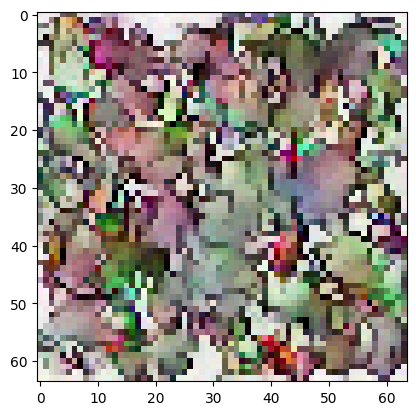

In [14]:
from IPython.display import clear_output

model = UNet(3, 3).to(device)
model.load_state_dict(torch.load('model.pt'))
model.eval()

with torch.no_grad():
    x = torch.randn((3,64,64), device=device)

    for t in reversed(range(T)):
        tt = torch.tensor(t, device=device)

        z = torch.randn((3,64,64), device=device) 
        e = model(x[None], tt)[0] * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])

        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
        
        #if t % 20 == 0:
        #    clear_output(wait=True)
        #    plot_image(x)

clear_output(wait=True)
plot_image(x)